In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

### 1. Read and visualize dataset

In [2]:
dataset_file = "./Data/LME COPPER PRICE.xlsx"
df = pd.read_excel(dataset_file, sheet_name='Sheet1')
df.dropna(inplace=True)
df.set_index('Date', inplace=True)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2004-01-02,2346.0,2349.0,2307.0,2307.0,580.0
2004-01-05,2376.0,2385.0,2354.0,2370.0,957.0
2004-01-06,2345.0,2391.0,2320.0,2378.0,1053.0
2004-01-07,2329.0,2360.0,2310.0,2335.0,1519.0
2004-01-08,2424.0,2425.0,2324.0,2350.0,1698.0


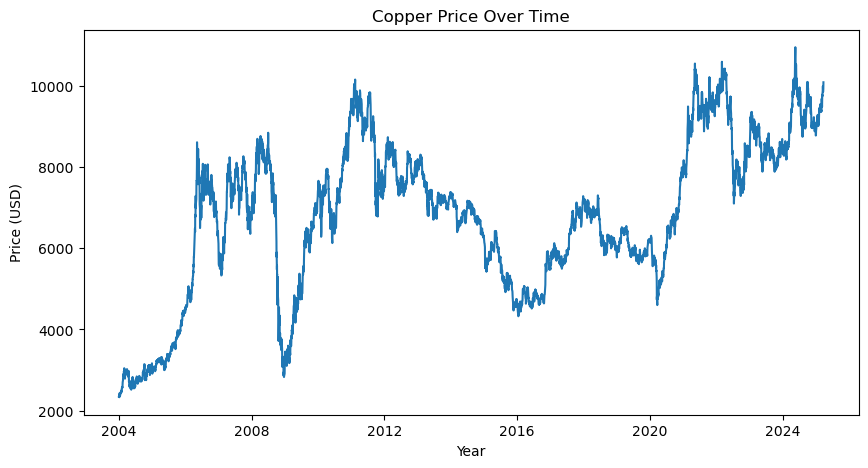

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(df.Close)
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("Copper Price Over Time")
plt.show()

### 2. Data processing for modeling

In [4]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((5365, 4), (5365,))

In [5]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

# Use input sequence of 30 to predict 10-day return
X_ss, y_mm = split_sequences(X_trans, y_trans, 30, 10)
print(X_trans.shape, y_trans.shape, X_ss.shape, y_mm.shape)

(5365, 4) (5365, 1) (5326, 30, 4) (5326, 10)


In [7]:
total_samples = len(X)
train_test_cutoff = round(0.95 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (5097, 30, 4) (5097, 10)
Testing Shape: (229, 30, 4) (229, 10)


In [8]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [9]:
# reshape to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 30, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 30, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([5097, 30, 4]) torch.Size([5097, 10])
Testing Shape: torch.Size([229, 30, 4]) torch.Size([229, 10])


### 3. LSTM model

In [10]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshape the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [11]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train,
                  X_test, y_test):

    # Initialize a list to log training/validation losses
    train_loss_logger = []
    val_loss_logger = []
    
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        
        # calculate loss
        loss = loss_fn(outputs, y_train)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        # Log the training loss
        train_loss_logger.append(loss.item())
        
        # validation loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)

        # Log the validation loss
        val_loss_logger.append(test_loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, train loss: {loss.item(): .5f}, test loss: {test_loss.item(): .5f}" )

    return train_loss_logger, val_loss_logger

#### 3.1 Define hyperparameters

In [68]:
n_epochs = 2000
learning_rate = 1e-3

input_size = 4
hidden_size = 16
num_layers = 1

num_classes = 10

lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#### 3.2 Model training

In [69]:
train_loss_logger, val_loss_logger = training_loop(n_epochs=n_epochs,
                                                   lstm=lstm,
                                                   optimizer=optimizer,
                                                   loss_fn=loss_fn,
                                                   X_train=X_train_tensors_final,
                                                   y_train=y_train_tensors,
                                                   X_test=X_test_tensors_final,
                                                   y_test=y_test_tensors)

Epoch: 0, train loss:  0.29929, test loss:  0.65752
Epoch: 100, train loss:  0.00184, test loss:  0.00198
Epoch: 200, train loss:  0.00101, test loss:  0.00127
Epoch: 300, train loss:  0.00096, test loss:  0.00124
Epoch: 400, train loss:  0.00093, test loss:  0.00127
Epoch: 500, train loss:  0.00089, test loss:  0.00132
Epoch: 600, train loss:  0.00084, test loss:  0.00118
Epoch: 700, train loss:  0.00082, test loss:  0.00105
Epoch: 800, train loss:  0.00080, test loss:  0.00100
Epoch: 900, train loss:  0.00079, test loss:  0.00098
Epoch: 1000, train loss:  0.00078, test loss:  0.00097
Epoch: 1100, train loss:  0.00077, test loss:  0.00096
Epoch: 1200, train loss:  0.00076, test loss:  0.00096
Epoch: 1300, train loss:  0.00076, test loss:  0.00095
Epoch: 1400, train loss:  0.00075, test loss:  0.00093
Epoch: 1500, train loss:  0.00074, test loss:  0.00092
Epoch: 1600, train loss:  0.00074, test loss:  0.00092
Epoch: 1700, train loss:  0.00073, test loss:  0.00093
Epoch: 1800, train los

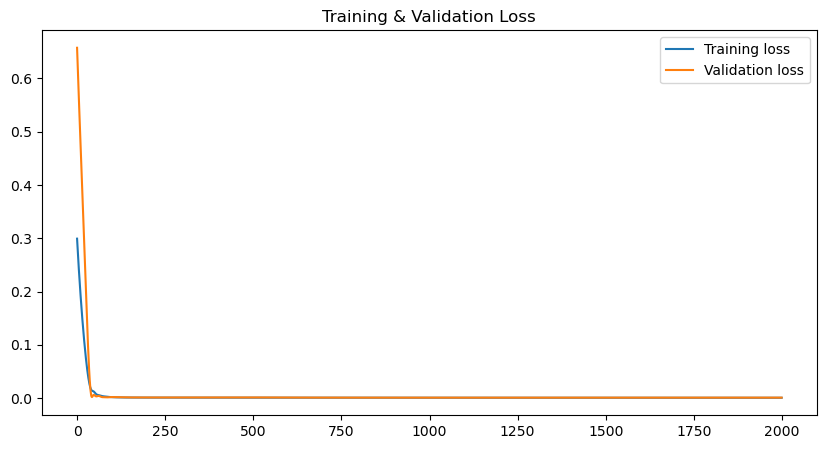

In [133]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_logger, label='Training loss')
plt.plot(val_loss_logger, label='Validation loss')
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

### 4. Model prediction

#### 4.1 Predict previous dates for compariosn and visualization

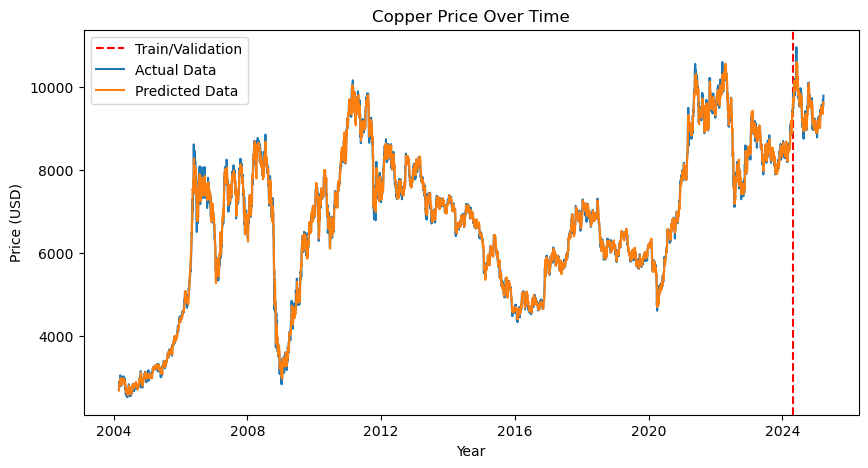

In [143]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 30, 10)
# convert to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshape the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 30, df_X_ss.shape[2]))

lstm.eval()

# Predict previous dates for compariosn and visualization
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
plt.figure(figsize=(10,5))
plt.axvline(df.index[-len(y_test)], c='r', linestyle='--', label='Train/Validation')
plt.plot(df.index[-len(true):], true, label='Actual Data') # actual plot
plt.plot(df.index[-len(true):], preds, label='Predicted Data') # predicted plot
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("Copper Price Over Time")
plt.legend()
plt.show()

#### 4.2 Predict prices of future 10 days

In [118]:
# use last 30 days as input sequence
X_last = X[-30 : ]
X_last = ss.fit_transform(X_last)

# convert to pytorch tensors
X_last_tensors = torch.Tensor(X_last).unsqueeze(0)

# reshaping to rows, timestamps, features
X_last_tensors = torch.reshape(X_last_tensors, 
                               (X_last_tensors.shape[0], 30, 
                                X_last_tensors.shape[2]))

print("Testing Shape:", X_last_tensors.shape)

Testing Shape: torch.Size([1, 30, 4])


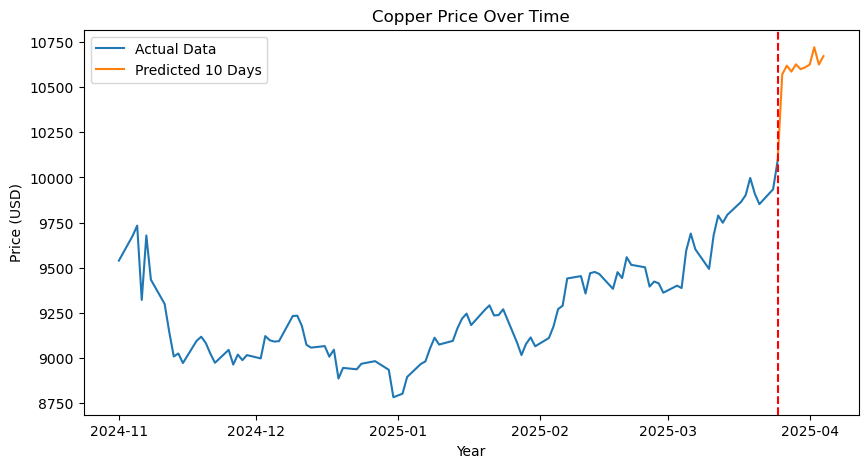

In [128]:
# predict prices of future 10 days
test_predict = lstm(X_last_tensors)
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

plt.figure(figsize=(10,5))
plt.plot(df.index[-100:], df.Close.iloc[-100:], label='Actual Data')
plt.plot([df.index[-1] + datetime.timedelta(days=i) for i in range(11)], [df.Close.iloc[-1]] + test_predict, label='Predicted 10 Days')
plt.axvline(x=df.index[-1], c='r', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("Copper Price Over Time")
plt.legend()
plt.show()